In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd

# Read the tab-separated .txt files
chimp = pd.read_csv("/kaggle/input/dna-sequence-dataset/chimpanzee.txt", sep="\t")
human = pd.read_csv("/kaggle/input/dna-sequence-dataset/human.txt", sep="\t")
dog = pd.read_csv("/kaggle/input/dna-sequence-dataset/dog.txt", sep="\t")

# ---------------------------
# Check missing values PER DATASET
# ---------------------------
print("Missing values before cleaning:\n")
print("Chimpanzee:\n", chimp.isnull().sum(), "\n")
print("Human:\n", human.isnull().sum(), "\n")
print("Dog:\n", dog.isnull().sum(), "\n")

# ---------------------------
# Drop missing values PER DATASET
# ---------------------------
chimp.dropna(inplace=True)
human.dropna(inplace=True)
dog.dropna(inplace=True)

# ---------------------------
# Combine all datasets
# ---------------------------
combined_dataset = pd.concat([chimp, human, dog], ignore_index=True)

# ---------------------------
# Final Validation
# ---------------------------
print("\nMissing values after cleaning (combined dataset):\n", combined_dataset.isnull().sum())

# Preview the cleaned combined dataset
print("\nCombined Dataset Preview:\n")
print(combined_dataset.head())



Missing values before cleaning:

Chimpanzee:
 sequence    0
class       0
dtype: int64 

Human:
 sequence    0
class       0
dtype: int64 

Dog:
 sequence    0
class       0
dtype: int64 


Missing values after cleaning (combined dataset):
 sequence    0
class       0
dtype: int64

Combined Dataset Preview:

                                            sequence  class
0  ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...      4
1  ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...      4
2  ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...      4
3  ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...      4
4  ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...      6


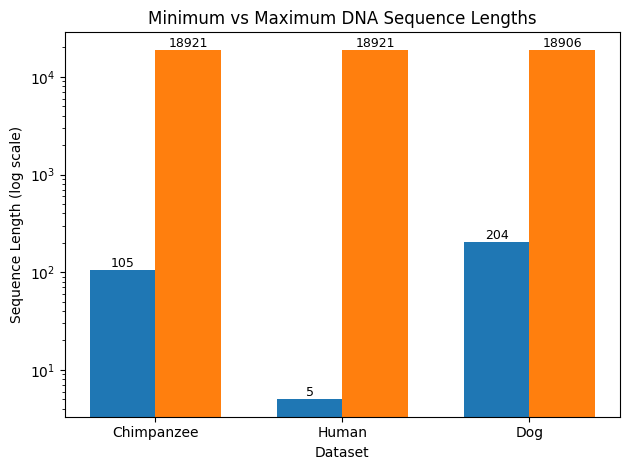

In [6]:
import matplotlib.pyplot as plt
import numpy as np
# Compute sequence lengths
chimp_len = chimp['sequence'].apply(len)
human_len = human['sequence'].apply(len)
dog_len   = dog['sequence'].apply(len)

# Collect stats
datasets = ["Chimpanzee", "Human", "Dog"]
min_lengths = [chimp_len.min(), human_len.min(), dog_len.min()]
max_lengths = [chimp_len.max(), human_len.max(), dog_len.max()]

# Bar positions
x = np.arange(len(datasets))
width = 0.35

# Plot
plt.figure()
plt.bar(x - width/2, min_lengths, width)
plt.bar(x + width/2, max_lengths, width)

plt.xticks(x, datasets)
plt.yscale("log")  # Important for visibility across huge range
plt.ylabel("Sequence Length (log scale)")
plt.xlabel("Dataset")
plt.title("Minimum vs Maximum DNA Sequence Lengths")

# Add value labels
for i in range(len(datasets)):
    plt.text(i - width/2, min_lengths[i], str(min_lengths[i]), ha='center', va='bottom', fontsize=9)
    plt.text(i + width/2, max_lengths[i], str(max_lengths[i]), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Chimpanzee Dataset

In [11]:
import pandas as pd
import numpy as np
import joblib
import random
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, normalize, label_binarize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, roc_auc_score,
    roc_curve, auc
)

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from statsmodels.stats.contingency_tables import mcnemar
from collections import defaultdict


In [51]:
# Reproducibility
np.random.seed(42)
random.seed(42)

# Load dataset
chimp = pd.read_csv("/kaggle/input/dna-sequence-dataset/chimpanzee.txt", sep="\t").dropna()

# Encode labels
le = LabelEncoder()
chimp["label"] = le.fit_transform(chimp["class"])
y = chimp["label"].values

# K-mer function
def kmers(seq, k=6):
    return [seq[i:i+k].lower() for i in range(len(seq) - k + 1)]

chimp["text"] = chimp["sequence"].apply(lambda x: " ".join(kmers(x)))

# Vectorization
cv = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
X = cv.fit_transform(chimp["text"])

# NOTE: Normalization intentionally REMOVED as requested

# Train-Test split (fixed for Stage 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# For AUC
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)


In [52]:
configs = {
    "MNB": [
        MultinomialNB(alpha=0.1),    # Low smoothing
        MultinomialNB(alpha=1.0),    # Default
        MultinomialNB(alpha=5.0)     # Heavy smoothing
    ],
    "LR": [
        LogisticRegression(C=0.1, max_iter=3000, solver="liblinear"),   # Strong regularization
        LogisticRegression(C=1.0, max_iter=3000, solver="liblinear"),   # Balanced
        LogisticRegression(C=10.0, max_iter=3000, solver="liblinear")   # Weak regularization
    ],
    "RF": [
        RandomForestClassifier(n_estimators=100, random_state=42),               # Light model
        RandomForestClassifier(n_estimators=300, random_state=42),               # More trees
        RandomForestClassifier(n_estimators=300, max_depth=30, random_state=42)  # Capacity controlled
    ]
}


In [53]:
def evaluate_model(model):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)

    metrics = {
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds, average="macro"),
        "Recall": recall_score(y_test, preds, average="macro"),
        "F1": f1_score(y_test, preds, average="macro"),
        "MCC": matthews_corrcoef(y_test, preds),
        "AUC": roc_auc_score(y_test_bin, probs, average="macro", multi_class="ovr"),
        "model": model,
        "pred": preds
    }
    return metrics


In [54]:
best_models = {}
stage1_results = {}

for model_name, model_list in configs.items():
    print(f"\n=========== STAGE 1: {model_name} TUNING ===========")
    scores = []

    for i, model in enumerate(model_list):
        res = evaluate_model(model)
        scores.append(res)

        print(f"\nConfig {i+1}")
        print("Accuracy :", res["Accuracy"])
        print("Precision:", res["Precision"])
        print("Recall   :", res["Recall"])
        print("F1-score :", res["F1"])
        print("MCC      :", res["MCC"])
        print("AUC-ROC  :", res["AUC"])

    # Select BEST by MCC, tie-breaker Macro-F1
    scores = sorted(scores, key=lambda x: (x["MCC"], x["F1"]), reverse=True)
    best = scores[0]

    best_models[model_name] = best["model"]
    stage1_results[model_name] = best
    joblib.dump(best["model"], f"{model_name}_best_chimp.pkl")

    print(f"\n✅ BEST {model_name} SELECTED")
    print("MCC      :", best["MCC"])
    print("F1-score :", best["F1"])
    print("AUC-ROC  :", best["AUC"])



=========== STAGE 1: MNB TUNING ===========

Config 1
Accuracy : 0.6142433234421365
Precision: 0.6530324121113594
Recall   : 0.6130655659348759
F1-score : 0.6118837248940604
MCC      : 0.543773332487621
AUC-ROC  : 0.8507508708418168

Config 2
Accuracy : 0.6142433234421365
Precision: 0.6482609787680105
Recall   : 0.6147314532390611
F1-score : 0.6129208938171302
MCC      : 0.5448203723852441
AUC-ROC  : 0.8499898248299902

Config 3
Accuracy : 0.6142433234421365
Precision: 0.6406390540811959
Recall   : 0.6163973405432464
F1-score : 0.6120105232925488
MCC      : 0.5450952146432873
AUC-ROC  : 0.8492528852026932

✅ BEST MNB SELECTED
MCC      : 0.5450952146432873
F1-score : 0.6120105232925488
AUC-ROC  : 0.8492528852026932

=========== STAGE 1: LR TUNING ===========

Config 1
Accuracy : 0.8991097922848664
Precision: 0.9182806035106632
Recall   : 0.8873824803240414
F1-score : 0.9015722859098508
MCC      : 0.876664171352918
AUC-ROC  : 0.972720069661685

Config 2
Accuracy : 0.9020771513353115
Pre

In [55]:
def robustness_test(model):
    metrics = defaultdict(list)

    for seed in [1,2,3,4,5]:
        Xt, Xv, yt, yv = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=seed
        )
        yv_bin = label_binarize(yv, classes=classes)

        model.fit(Xt, yt)
        preds = model.predict(Xv)
        probs = model.predict_proba(Xv)

        metrics["Accuracy"].append(accuracy_score(yv, preds))
        metrics["F1"].append(f1_score(yv, preds, average="macro"))
        metrics["MCC"].append(matthews_corrcoef(yv, preds))
        metrics["AUC"].append(roc_auc_score(yv_bin, probs, average="macro", multi_class="ovr"))

    return metrics


In [56]:
robust_results = {}

for name, model in best_models.items():
    print(f"\n=========== STAGE 2: ROBUSTNESS — {name} ===========")
    res = robustness_test(model)
    robust_results[name] = res

    for metric, values in res.items():
        print(f"{metric}: {np.mean(values):.4f} ± {np.std(values):.4f}")



=========== STAGE 2: ROBUSTNESS — MNB ===========
Accuracy: 0.5964 ± 0.0212
F1: 0.5899 ± 0.0205
MCC: 0.5285 ± 0.0229
AUC: 0.8472 ± 0.0153

=========== STAGE 2: ROBUSTNESS — LR ===========
Accuracy: 0.8991 ± 0.0145
F1: 0.9012 ± 0.0168
MCC: 0.8768 ± 0.0179
AUC: 0.9818 ± 0.0040

=========== STAGE 2: ROBUSTNESS — RF ===========
Accuracy: 0.8326 ± 0.0141
F1: 0.8425 ± 0.0191
MCC: 0.8008 ± 0.0163
AUC: 0.9727 ± 0.0079


In [57]:
def correct_predictions(model):
    model.fit(X_train, y_train)
    return (model.predict(X_test) == y_test)

# Pick best model by mean MCC
mean_mcc = {k: np.mean(v["MCC"]) for k,v in robust_results.items()}
best_name = max(mean_mcc, key=mean_mcc.get)
best_model = best_models[best_name]

print("\n🏆 OVERALL BEST MODEL:", best_name)

best_correct = correct_predictions(best_model)

for name, model in best_models.items():
    if name == best_name:
        continue

    other_correct = correct_predictions(model)

    table = [
        [np.sum(best_correct & other_correct), np.sum(best_correct & ~other_correct)],
        [np.sum(~best_correct & other_correct), np.sum(~best_correct & ~other_correct)]
    ]

    result = mcnemar(table, exact=True)

    print(f"\nMcNemar Test: {best_name} vs {name}")
    print("Contingency Table:", table)
    print("p-value:", result.pvalue)



🏆 OVERALL BEST MODEL: LR

McNemar Test: LR vs MNB
Contingency Table: [[196, 108], [11, 22]]
p-value: 3.5244459526876745e-21

McNemar Test: LR vs RF
Contingency Table: [[270, 34], [6, 27]]
p-value: 8.364584573428147e-06


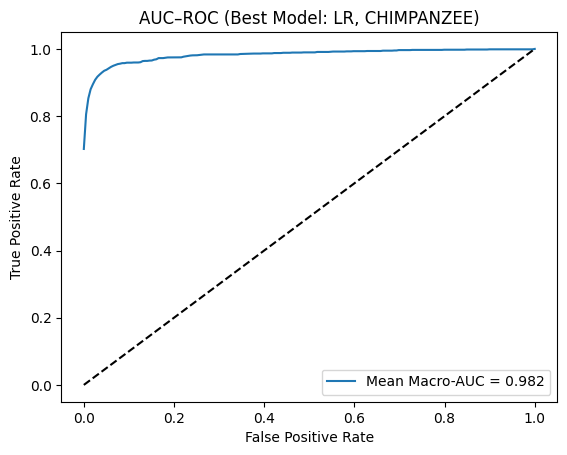

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

# Seeds used in robustness
seeds = [1, 2, 3, 4, 5]

# Common FPR grid for interpolation
fpr_grid = np.linspace(0, 1, 200)

# Store all interpolated TPRs
mean_tprs = []

for seed in seeds:
    # Split (same as robustness stage)
    Xt, Xv, yt, yv = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=seed
    )

    # Binarize labels
    yv_bin = label_binarize(yv, classes=classes)

    # Train best model
    best_model.fit(Xt, yt)
    probs = best_model.predict_proba(Xv)

    # Compute ROC for each class, then macro-average
    tprs = []

    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(yv_bin[:, i], probs[:, i])
        tprs.append(np.interp(fpr_grid, fpr, tpr))

    # Macro curve for this split
    mean_tprs.append(np.mean(tprs, axis=0))

# Final mean ROC curve across seeds
final_mean_tpr = np.mean(mean_tprs, axis=0)
final_auc = auc(fpr_grid, final_mean_tpr)

# Plot
plt.figure()
plt.plot(fpr_grid, final_mean_tpr, label=f"Mean Macro-AUC = {final_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"AUC–ROC (Best Model: {best_name}, CHIMPANZEE)")
plt.legend()
plt.show()


# Human Dataset

In [25]:
# Reproducibility
np.random.seed(42)
random.seed(42)

# Load HUMAN dataset
human = pd.read_csv("/kaggle/input/dna-sequence-dataset/human.txt", sep="\t").dropna()

# Encode labels
le = LabelEncoder()
human["label"] = le.fit_transform(human["class"])
y = human["label"].values

# k-mer function (k = 6)
def kmers(seq, k=6):
    return [seq[i:i+k].lower() for i in range(len(seq) - k + 1)]

human["text"] = human["sequence"].apply(lambda x: " ".join(kmers(x, 6)))

# Vectorization (NO normalization per your instruction)
cv = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
X = cv.fit_transform(human["text"])

# Fixed split for Stage-1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# For AUC
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)


In [26]:
configs = {
    "MNB": [
        MultinomialNB(alpha=0.1),   # low smoothing
        MultinomialNB(alpha=1.0),   # default
        MultinomialNB(alpha=5.0)    # heavy smoothing
    ],
    "LR": [
        LogisticRegression(C=0.1, max_iter=3000, solver="liblinear"),  # strong regularization
        LogisticRegression(C=1.0, max_iter=3000, solver="liblinear"),  # balanced
        LogisticRegression(C=10.0, max_iter=3000, solver="liblinear")  # weak regularization
    ],
    "RF": [
        RandomForestClassifier(n_estimators=100, random_state=42),
        RandomForestClassifier(n_estimators=300, random_state=42),
        RandomForestClassifier(n_estimators=300, max_depth=30, random_state=42)
    ]
}


In [27]:
def evaluate_model(model):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)

    return {
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds, average="macro"),
        "Recall": recall_score(y_test, preds, average="macro"),
        "F1": f1_score(y_test, preds, average="macro"),
        "MCC": matthews_corrcoef(y_test, preds),
        "AUC": roc_auc_score(y_test_bin, probs, average="macro", multi_class="ovr"),
        "model": model,
        "pred": preds
    }


In [28]:
best_models = {}
stage1_results = {}

for model_name, model_list in configs.items():
    print(f"\n=========== STAGE 1: {model_name} TUNING (HUMAN) ===========")
    scores = []

    for i, model in enumerate(model_list):
        res = evaluate_model(model)
        scores.append(res)

        print(f"\nConfig {i+1}")
        print("Accuracy :", res["Accuracy"])
        print("Precision:", res["Precision"])
        print("Recall   :", res["Recall"])
        print("F1-score :", res["F1"])
        print("MCC      :", res["MCC"])
        print("AUC-ROC  :", res["AUC"])

    # Select BEST by MCC, tie-breaker Macro-F1
    scores = sorted(scores, key=lambda x: (x["MCC"], x["F1"]), reverse=True)
    best = scores[0]

    best_models[model_name] = best["model"]
    stage1_results[model_name] = best
    joblib.dump(best["model"], f"{model_name}_best_human.pkl")

    print(f"\n✅ BEST {model_name} SELECTED (HUMAN)")
    print("MCC      :", best["MCC"])
    print("F1-score :", best["F1"])
    print("AUC-ROC  :", best["AUC"])



=========== STAGE 1: MNB TUNING (HUMAN) ===========

Config 1
Accuracy : 0.6073059360730594
Precision: 0.6613784191731356
Recall   : 0.6124038090088934
F1-score : 0.609874321541008
MCC      : 0.5460745079151811
AUC-ROC  : 0.8475601832086951

Config 2
Accuracy : 0.6050228310502284
Precision: 0.6609127729665738
Recall   : 0.6103316747105662
F1-score : 0.6079781996693991
MCC      : 0.5437984153990403
AUC-ROC  : 0.8468465011539171

Config 3
Accuracy : 0.5981735159817352
Precision: 0.6546806922477101
Recall   : 0.6035310837282316
F1-score : 0.6004837421459763
MCC      : 0.535724474798648
AUC-ROC  : 0.8452375311356358

✅ BEST MNB SELECTED (HUMAN)
MCC      : 0.5460745079151811
F1-score : 0.609874321541008
AUC-ROC  : 0.8475601832086951

=========== STAGE 1: LR TUNING (HUMAN) ===========

Config 1
Accuracy : 0.9235159817351598
Precision: 0.9346052105269279
Recall   : 0.9058159490783407
F1-score : 0.9180804779349286
MCC      : 0.9063009111635507
AUC-ROC  : 0.9840710389896331

Config 2
Accuracy 

In [29]:
def robustness_test(model):
    metrics = defaultdict(list)
    for seed in [1, 2, 3, 4, 5]:
        Xt, Xv, yt, yv = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=seed
        )
        yv_bin = label_binarize(yv, classes=classes)

        model.fit(Xt, yt)
        preds = model.predict(Xv)
        probs = model.predict_proba(Xv)

        metrics["Accuracy"].append(accuracy_score(yv, preds))
        metrics["F1"].append(f1_score(yv, preds, average="macro"))
        metrics["MCC"].append(matthews_corrcoef(yv, preds))
        metrics["AUC"].append(roc_auc_score(yv_bin, probs, average="macro", multi_class="ovr"))
    return metrics


In [30]:
robust_results = {}

for name, model in best_models.items():
    print(f"\n=========== STAGE 2: ROBUSTNESS — {name} (HUMAN) ===========")
    res = robustness_test(model)
    robust_results[name] = res
    for metric, values in res.items():
        print(f"{metric}: {np.mean(values):.4f} ± {np.std(values):.4f}")



=========== STAGE 2: ROBUSTNESS — MNB (HUMAN) ===========
Accuracy: 0.6247 ± 0.0131
F1: 0.6211 ± 0.0119
MCC: 0.5617 ± 0.0135
AUC: 0.8691 ± 0.0127

=========== STAGE 2: ROBUSTNESS — LR (HUMAN) ===========
Accuracy: 0.9103 ± 0.0092
F1: 0.9050 ± 0.0129
MCC: 0.8901 ± 0.0114
AUC: 0.9847 ± 0.0023

=========== STAGE 2: ROBUSTNESS — RF (HUMAN) ===========
Accuracy: 0.8523 ± 0.0078
F1: 0.8544 ± 0.0140
MCC: 0.8252 ± 0.0095
AUC: 0.9841 ± 0.0040


In [31]:
def correct_predictions(model):
    model.fit(X_train, y_train)
    return (model.predict(X_test) == y_test)

# Select overall best by mean MCC
mean_mcc = {k: np.mean(v["MCC"]) for k, v in robust_results.items()}
best_name = max(mean_mcc, key=mean_mcc.get)
best_model = best_models[best_name]

print("\n🏆 OVERALL BEST MODEL (HUMAN):", best_name)

best_correct = correct_predictions(best_model)

for name, model in best_models.items():
    if name == best_name:
        continue
    other_correct = correct_predictions(model)

    table = [
        [np.sum(best_correct & other_correct), np.sum(best_correct & ~other_correct)],
        [np.sum(~best_correct & other_correct), np.sum(~best_correct & ~other_correct)]
    ]
    res = mcnemar(table, exact=True)

    print(f"\nMcNemar Test: {best_name} vs {name} (HUMAN)")
    print("Contingency Table:", table)
    print("p-value:", res.pvalue)



🏆 OVERALL BEST MODEL (HUMAN): LR

McNemar Test: LR vs MNB (HUMAN)
Contingency Table: [[513, 296], [19, 48]]
p-value: 4.440900146496189e-65

McNemar Test: LR vs RF (HUMAN)
Contingency Table: [[751, 58], [17, 50]]
p-value: 2.1823279653758543e-06


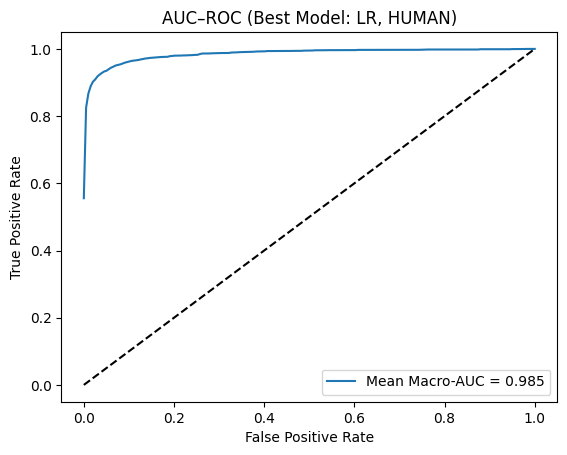

In [32]:
# Mean macro AUC–ROC across the same 5 splits
seeds = [1, 2, 3, 4, 5]
fpr_grid = np.linspace(0, 1, 200)
mean_tprs = []

for seed in seeds:
    Xt, Xv, yt, yv = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=seed
    )
    yv_bin = label_binarize(yv, classes=classes)

    best_model.fit(Xt, yt)
    probs = best_model.predict_proba(Xv)

    tprs = []
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(yv_bin[:, i], probs[:, i])
        tprs.append(np.interp(fpr_grid, fpr, tpr))
    mean_tprs.append(np.mean(tprs, axis=0))

final_mean_tpr = np.mean(mean_tprs, axis=0)
final_auc = auc(fpr_grid, final_mean_tpr)

plt.figure()
plt.plot(fpr_grid, final_mean_tpr, label=f"Mean Macro-AUC = {final_auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"AUC–ROC (Best Model: {best_name}, HUMAN)")
plt.legend()
plt.show()


# Dog Dataset

In [33]:
# Reproducibility
np.random.seed(42)
random.seed(42)

# Load DOG dataset
dog = pd.read_csv("/kaggle/input/dna-sequence-dataset/dog.txt", sep="\t").dropna()

# Encode labels
le = LabelEncoder()
dog["label"] = le.fit_transform(dog["class"])
y = dog["label"].values

# k-mer function (k = 6)
def kmers(seq, k=6):
    return [seq[i:i+k].lower() for i in range(len(seq) - k + 1)]

dog["text"] = dog["sequence"].apply(lambda x: " ".join(kmers(x, 6)))

# Vectorization (NO normalization)
cv = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
X = cv.fit_transform(dog["text"])

# Fixed split for Stage-1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# For AUC
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)


In [34]:
configs = {
    "MNB": [
        MultinomialNB(alpha=0.1),   # low smoothing
        MultinomialNB(alpha=1.0),   # default
        MultinomialNB(alpha=5.0)    # heavy smoothing
    ],
    "LR": [
        LogisticRegression(C=0.1, max_iter=3000, solver="liblinear"),
        LogisticRegression(C=1.0, max_iter=3000, solver="liblinear"),
        LogisticRegression(C=10.0, max_iter=3000, solver="liblinear")
    ],
    "RF": [
        RandomForestClassifier(n_estimators=100, random_state=42),
        RandomForestClassifier(n_estimators=300, random_state=42),
        RandomForestClassifier(n_estimators=300, max_depth=30, random_state=42)
    ]
}


In [35]:
def evaluate_model(model):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)

    return {
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds, average="macro"),
        "Recall": recall_score(y_test, preds, average="macro"),
        "F1": f1_score(y_test, preds, average="macro"),
        "MCC": matthews_corrcoef(y_test, preds),
        "AUC": roc_auc_score(y_test_bin, probs, average="macro", multi_class="ovr"),
        "model": model,
        "pred": preds
    }


In [36]:
best_models = {}
stage1_results = {}

for model_name, model_list in configs.items():
    print(f"\n=========== STAGE 1: {model_name} TUNING (DOG) ===========")
    scores = []

    for i, model in enumerate(model_list):
        res = evaluate_model(model)
        scores.append(res)

        print(f"\nConfig {i+1}")
        print("Accuracy :", res["Accuracy"])
        print("Precision:", res["Precision"])
        print("Recall   :", res["Recall"])
        print("F1-score :", res["F1"])
        print("MCC      :", res["MCC"])
        print("AUC-ROC  :", res["AUC"])

    # Select BEST by MCC, tie-breaker Macro-F1
    scores = sorted(scores, key=lambda x: (x["MCC"], x["F1"]), reverse=True)
    best = scores[0]

    best_models[model_name] = best["model"]
    stage1_results[model_name] = best
    joblib.dump(best["model"], f"{model_name}_best_dog.pkl")

    print(f"\n✅ BEST {model_name} SELECTED (DOG)")
    print("MCC      :", best["MCC"])
    print("F1-score :", best["F1"])
    print("AUC-ROC  :", best["AUC"])



=========== STAGE 1: MNB TUNING (DOG) ===========

Config 1
Accuracy : 0.573170731707317
Precision: 0.5675697865353037
Recall   : 0.5178212625581046
F1-score : 0.5332145229976358
MCC      : 0.4709594097004417
AUC-ROC  : 0.8219392445932082

Config 2
Accuracy : 0.573170731707317
Precision: 0.5634938624593797
Recall   : 0.5178212625581046
F1-score : 0.5309823638743499
MCC      : 0.47161660561425883
AUC-ROC  : 0.8260266929209248

Config 3
Accuracy : 0.6158536585365854
Precision: 0.6529911798882074
Recall   : 0.5632735685367265
F1-score : 0.5818026312735435
MCC      : 0.5239165855723668
AUC-ROC  : 0.8255565661898315

✅ BEST MNB SELECTED (DOG)
MCC      : 0.5239165855723668
F1-score : 0.5818026312735435
AUC-ROC  : 0.8255565661898315

=========== STAGE 1: LR TUNING (DOG) ===========

Config 1
Accuracy : 0.7134146341463414
Precision: 0.7825666239200073
Recall   : 0.6421802369170789
F1-score : 0.6842937699197638
MCC      : 0.6463798958632768
AUC-ROC  : 0.879985977780038

Config 2
Accuracy : 0.7

In [37]:
def robustness_test(model):
    metrics = defaultdict(list)
    for seed in [1, 2, 3, 4, 5]:
        Xt, Xv, yt, yv = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=seed
        )
        yv_bin = label_binarize(yv, classes=classes)

        model.fit(Xt, yt)
        preds = model.predict(Xv)
        probs = model.predict_proba(Xv)

        metrics["Accuracy"].append(accuracy_score(yv, preds))
        metrics["F1"].append(f1_score(yv, preds, average="macro"))
        metrics["MCC"].append(matthews_corrcoef(yv, preds))
        metrics["AUC"].append(roc_auc_score(yv_bin, probs, average="macro", multi_class="ovr"))
    return metrics


In [38]:
robust_results = {}

for name, model in best_models.items():
    print(f"\n=========== STAGE 2: ROBUSTNESS — {name} (DOG) ===========")
    res = robustness_test(model)
    robust_results[name] = res
    for metric, values in res.items():
        print(f"{metric}: {np.mean(values):.4f} ± {np.std(values):.4f}")



=========== STAGE 2: ROBUSTNESS — MNB (DOG) ===========
Accuracy: 0.5549 ± 0.0193
F1: 0.5205 ± 0.0240
MCC: 0.4651 ± 0.0241
AUC: 0.8107 ± 0.0306

=========== STAGE 2: ROBUSTNESS — LR (DOG) ===========
Accuracy: 0.7598 ± 0.0300
F1: 0.7389 ± 0.0246
MCC: 0.7029 ± 0.0380
AUC: 0.9251 ± 0.0219

=========== STAGE 2: ROBUSTNESS — RF (DOG) ===========
Accuracy: 0.6220 ± 0.0128
F1: 0.5937 ± 0.0307
MCC: 0.5341 ± 0.0174
AUC: 0.8896 ± 0.0188


In [39]:
def correct_predictions(model):
    model.fit(X_train, y_train)
    return (model.predict(X_test) == y_test)

# Determine best model by mean MCC
mean_mcc = {k: np.mean(v["MCC"]) for k, v in robust_results.items()}
best_name = max(mean_mcc, key=mean_mcc.get)
best_model = best_models[best_name]

print("\n🏆 OVERALL BEST MODEL (DOG):", best_name)

best_correct = correct_predictions(best_model)

for name, model in best_models.items():
    if name == best_name:
        continue
    other_correct = correct_predictions(model)

    table = [
        [np.sum(best_correct & other_correct), np.sum(best_correct & ~other_correct)],
        [np.sum(~best_correct & other_correct), np.sum(~best_correct & ~other_correct)]
    ]

    res = mcnemar(table, exact=True)

    print(f"\nMcNemar Test: {best_name} vs {name} (DOG)")
    print("Contingency Table:", table)
    print("p-value:", res.pvalue)



🏆 OVERALL BEST MODEL (DOG): LR

McNemar Test: LR vs MNB (DOG)
Contingency Table: [[86, 32], [15, 31]]
p-value: 0.018623836615006432

McNemar Test: LR vs RF (DOG)
Contingency Table: [[89, 29], [6, 40]]
p-value: 0.0001168418675661087


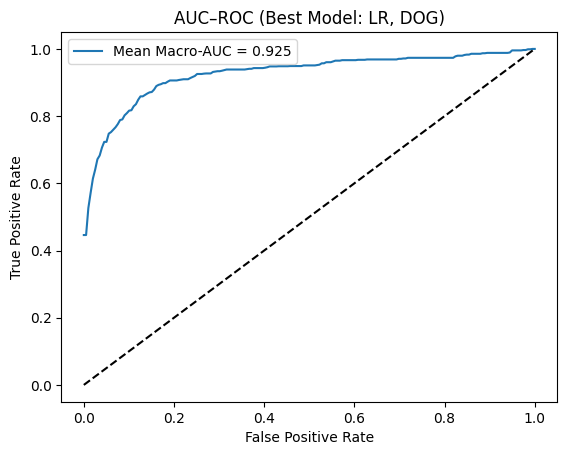

In [40]:
seeds = [1, 2, 3, 4, 5]
fpr_grid = np.linspace(0, 1, 200)
mean_tprs = []

for seed in seeds:
    Xt, Xv, yt, yv = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=seed
    )
    yv_bin = label_binarize(yv, classes=classes)

    best_model.fit(Xt, yt)
    probs = best_model.predict_proba(Xv)

    tprs = []
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(yv_bin[:, i], probs[:, i])
        tprs.append(np.interp(fpr_grid, fpr, tpr))
    mean_tprs.append(np.mean(tprs, axis=0))

final_mean_tpr = np.mean(mean_tprs, axis=0)
final_auc = auc(fpr_grid, final_mean_tpr)

plt.figure()
plt.plot(fpr_grid, final_mean_tpr, label=f"Mean Macro-AUC = {final_auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"AUC–ROC (Best Model: {best_name}, DOG)")
plt.legend()
plt.show()


# Combined Dataset

In [41]:
# Reproducibility
np.random.seed(42)
random.seed(42)

# Load & combine datasets
chimp = pd.read_csv("/kaggle/input/dna-sequence-dataset/chimpanzee.txt", sep="\t").dropna()
human = pd.read_csv("/kaggle/input/dna-sequence-dataset/human.txt", sep="\t").dropna()
dog   = pd.read_csv("/kaggle/input/dna-sequence-dataset/dog.txt", sep="\t").dropna()

combined = pd.concat([chimp, human, dog], ignore_index=True)

# Encode labels
le = LabelEncoder()
combined["label"] = le.fit_transform(combined["class"])
y = combined["label"].values

# k-mer function (k = 6)
def kmers(seq, k=6):
    return [seq[i:i+k].lower() for i in range(len(seq) - k + 1)]

combined["text"] = combined["sequence"].apply(lambda x: " ".join(kmers(x, 6)))

# Vectorization
cv = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
X = cv.fit_transform(combined["text"])

# Fixed split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# For AUC
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)


In [42]:
configs = {
    "MNB": [
        MultinomialNB(alpha=0.1),
        MultinomialNB(alpha=1.0),
        MultinomialNB(alpha=5.0)
    ],
    "LR": [
        LogisticRegression(C=0.1, max_iter=3000, solver="liblinear"),
        LogisticRegression(C=1.0, max_iter=3000, solver="liblinear"),
        LogisticRegression(C=10.0, max_iter=3000, solver="liblinear")
    ],
    "RF": [
        RandomForestClassifier(n_estimators=100, random_state=42),
        RandomForestClassifier(n_estimators=300, random_state=42),
        RandomForestClassifier(n_estimators=300, max_depth=30, random_state=42)
    ]
}


In [43]:
def evaluate_model(model):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)

    return {
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds, average="macro"),
        "Recall": recall_score(y_test, preds, average="macro"),
        "F1": f1_score(y_test, preds, average="macro"),
        "MCC": matthews_corrcoef(y_test, preds),
        "AUC": roc_auc_score(y_test_bin, probs, average="macro", multi_class="ovr"),
        "model": model,
        "pred": preds
    }


In [44]:
best_models = {}
stage1_results = {}

for model_name, model_list in configs.items():
    print(f"\n=========== STAGE 1: {model_name} TUNING (COMBINED) ===========")
    scores = []

    for i, model in enumerate(model_list):
        res = evaluate_model(model)
        scores.append(res)

        print(f"\nConfig {i+1}")
        print("Accuracy :", res["Accuracy"])
        print("Precision:", res["Precision"])
        print("Recall   :", res["Recall"])
        print("F1-score :", res["F1"])
        print("MCC      :", res["MCC"])
        print("AUC-ROC  :", res["AUC"])

    # Best by MCC, tie-break by F1
    scores = sorted(scores, key=lambda x: (x["MCC"], x["F1"]), reverse=True)
    best = scores[0]
    
    best_models[model_name] = best["model"]
    stage1_results[model_name] = best
    joblib.dump(best["model"], f"{model_name}_best_combined.pkl")

    print(f"\n✅ BEST {model_name} SELECTED (COMBINED)")
    print("MCC      :", best["MCC"])
    print("F1-score :", best["F1"])
    print("AUC-ROC  :", best["AUC"])



=========== STAGE 1: MNB TUNING (COMBINED) ===========

Config 1
Accuracy : 0.6608569353667393
Precision: 0.6648746951132632
Recall   : 0.6759444629149078
F1-score : 0.6569810271572569
MCC      : 0.6014808863933748
AUC-ROC  : 0.8768838845047684

Config 2
Accuracy : 0.6601307189542484
Precision: 0.664879665575337
Recall   : 0.675375336717641
F1-score : 0.6566915595344263
MCC      : 0.6005619963262453
AUC-ROC  : 0.8768087056658216

Config 3
Accuracy : 0.6601307189542484
Precision: 0.6631943604517427
Recall   : 0.6744522851550202
F1-score : 0.6554781557261942
MCC      : 0.6004120605349849
AUC-ROC  : 0.876562465476104

✅ BEST MNB SELECTED (COMBINED)
MCC      : 0.6014808863933748
F1-score : 0.6569810271572569
AUC-ROC  : 0.8768838845047684

=========== STAGE 1: LR TUNING (COMBINED) ===========

Config 1
Accuracy : 0.9382716049382716
Precision: 0.9422099861339925
Recall   : 0.9340433538255837
F1-score : 0.937880533080424
MCC      : 0.9244264069948296
AUC-ROC  : 0.9946802415734028

Config 2
A

In [45]:
def robustness_test(model):
    metrics = defaultdict(list)
    for seed in [1, 2, 3, 4, 5]:
        Xt, Xv, yt, yv = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=seed
        )
        yv_bin = label_binarize(yv, classes=classes)

        model.fit(Xt, yt)
        preds = model.predict(Xv)
        probs = model.predict_proba(Xv)

        metrics["Accuracy"].append(accuracy_score(yv, preds))
        metrics["F1"].append(f1_score(yv, preds, average="macro"))
        metrics["MCC"].append(matthews_corrcoef(yv, preds))
        metrics["AUC"].append(roc_auc_score(yv_bin, probs, average="macro", multi_class="ovr"))
    return metrics


In [46]:
robust_results = {}

for name, model in best_models.items():
    print(f"\n=========== STAGE 2: ROBUSTNESS — {name} (COMBINED) ===========")
    res = robustness_test(model)
    robust_results[name] = res
    for metric, values in res.items():
        print(f"{metric}: {np.mean(values):.4f} ± {np.std(values):.4f}")



=========== STAGE 2: ROBUSTNESS — MNB (COMBINED) ===========
Accuracy: 0.6277 ± 0.0038
F1: 0.6282 ± 0.0062
MCC: 0.5670 ± 0.0049
AUC: 0.8638 ± 0.0073

=========== STAGE 2: ROBUSTNESS — LR (COMBINED) ===========
Accuracy: 0.9467 ± 0.0054
F1: 0.9445 ± 0.0053
MCC: 0.9348 ± 0.0066
AUC: 0.9933 ± 0.0012

=========== STAGE 2: ROBUSTNESS — RF (COMBINED) ===========
Accuracy: 0.9156 ± 0.0034
F1: 0.9216 ± 0.0038
MCC: 0.8987 ± 0.0041
AUC: 0.9938 ± 0.0006


In [47]:
def correct_predictions(model):
    model.fit(X_train, y_train)
    return (model.predict(X_test) == y_test)

mean_mcc = {k: np.mean(v["MCC"]) for k, v in robust_results.items()}
best_name = max(mean_mcc, key=mean_mcc.get)
best_model = best_models[best_name]

print("\n🏆 OVERALL BEST MODEL (COMBINED):", best_name)

best_correct = correct_predictions(best_model)

for name, model in best_models.items():
    if name == best_name:
        continue

    other_correct = correct_predictions(model)

    table = [
        [np.sum(best_correct & other_correct), np.sum(best_correct & ~other_correct)],
        [np.sum(~best_correct & other_correct), np.sum(~best_correct & ~other_correct)]
    ]

    res = mcnemar(table, exact=True)
    
    print(f"\nMcNemar Test: {best_name} vs {name} (COMBINED)")
    print("Contingency Table:", table)
    print("p-value:", res.pvalue)



🏆 OVERALL BEST MODEL (COMBINED): LR

McNemar Test: LR vs MNB (COMBINED)
Contingency Table: [[890, 402], [20, 65]]
p-value: 1.6215192758438859e-93

McNemar Test: LR vs RF (COMBINED)
Contingency Table: [[1217, 75], [28, 57]]
p-value: 4.027763000797049e-06


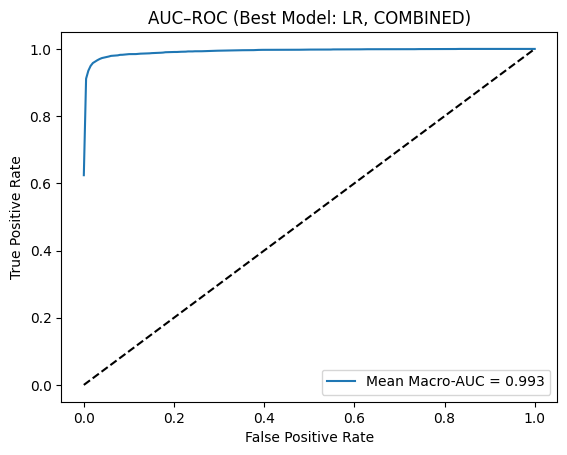

In [48]:
seeds = [1, 2, 3, 4, 5]
fpr_grid = np.linspace(0, 1, 200)
mean_tprs = []

for seed in seeds:
    Xt, Xv, yt, yv = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=seed
    )
    yv_bin = label_binarize(yv, classes=classes)

    best_model.fit(Xt, yt)
    probs = best_model.predict_proba(Xv)

    tprs = []
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(yv_bin[:, i], probs[:, i])
        tprs.append(np.interp(fpr_grid, fpr, tpr))

    mean_tprs.append(np.mean(tprs, axis=0))

final_mean_tpr = np.mean(mean_tprs, axis=0)
final_auc = auc(fpr_grid, final_mean_tpr)

plt.figure()
plt.plot(fpr_grid, final_mean_tpr, label=f"Mean Macro-AUC = {final_auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"AUC–ROC (Best Model: {best_name}, COMBINED)")
plt.legend()
plt.show()
